# Module 8: 時間序列特徵工程 - 4. 季節性與趨勢分解 (Seasonality and Trend Decomposition)

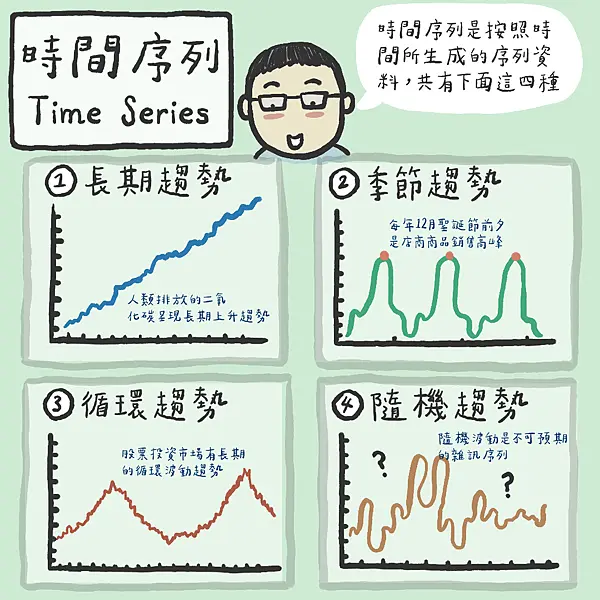


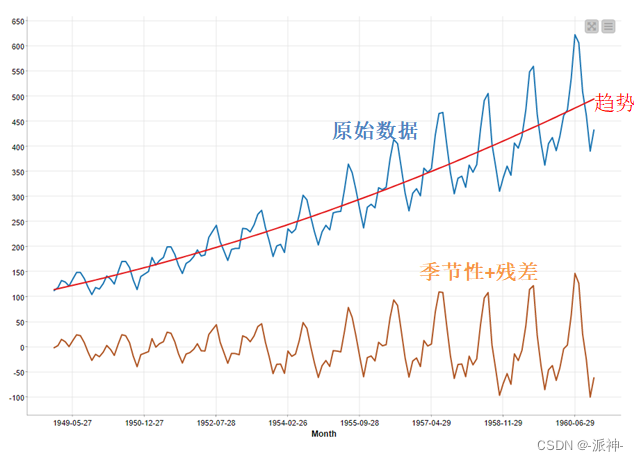

## 學習目標
- 理解時間序列分解的基本概念，包括趨勢 (Trend)、季節性 (Seasonality) 和殘差 (Residual) 三個主要成分。
- 學習並區分加法模型 (Additive Model) 和乘法模型 (Multiplicative Model) 在時間序列分解中的適用場景。
- 掌握如何使用 `statsmodels.tsa.seasonal.seasonal_decompose` 函數對時間序列進行分解。
- 了解如何利用分解後的趨勢、季節性成分作為新的特徵，或創建去季節性/去趨勢的序列，以提升模型性能。
- 透過視覺化工具分析分解結果，深入理解時間序列的內在結構。

## 導論：如何「剖析」時間序列，揭示其深層結構？

在時間序列數據中，觀測到的值往往是多種潛在模式疊加的結果。就像一首複雜的交響樂，它可能由緩慢變化的主旋律、重複出現的副歌，以及一些隨機的即興演奏共同構成。在時間序列分析中，這些「構成部分」通常被稱為：**趨勢 (Trend)**、**季節性 (Seasonality)** 和**殘差 (Residual)**。

**時間序列分解 (Time Series Decomposition)** 正是這樣一種強大的分析技術，它旨在將一個原始時間序列拆解成這些單獨的、可解釋的組成部分。您的指南明確指出：「*分解可以幫助我們更好地理解時間序列的內在結構和驅動因素。*」這不僅能加深我們對資料行為的理解，更能為特徵工程和模型選擇提供關鍵指引。

### 時間序列的三大構成要素：
1.  **趨勢 (Trend)**: 指的是資料在長期內的總體方向或緩慢的、持續性的變動。它可以是上升的（如全球氣溫的逐步升高）、下降的（如傳統報紙銷量的逐年減少）或相對平穩的。
2.  **季節性 (Seasonality)**: 指的是在固定時間間隔內（如每小時、每天、每週、每月、每季度或每年）重複出現的模式或週期性波動。例如，商店在週末的銷售額普遍高於平日，或冰淇淋銷量在夏季總是達到高峰。
3.  **殘差 (Residual / Noise)**: 移除趨勢和季節性成分後，時間序列中剩餘的、隨機的、不可解釋的波動。理想情況下，殘差應該接近白噪音（即沒有明顯的模式或可預測性）。

### 為什麼時間序列分解至關重要？
-   **深入理解資料行為**：分解能幫助我們直觀地看到資料的長期走向、重複模式以及不可預測的噪音，從而對其生成機制有更全面的洞察。
-   **強大的特徵工程**：分解出的趨勢和季節性成分本身就是極具預測能力的特徵。我們可以將它們直接納入機器學習模型，或者利用它們來創建去季節性 (de-seasonalized) 或去趨勢 (de-trended) 的序列，為模型提供更「純粹」的預測信號。
-   **簡化模型預處理**：對於一些傳統的時間序列模型（如 ARIMA），通常要求輸入的序列是平穩的 (stationary)——即均值和方差不隨時間變化，且沒有季節性。分解可以幫助我們識別並去除這些非平穩成分，簡化後續的建模過程。

--- 

## 分解模型：加法與乘法

在執行時間序列分解時，我們需要選擇一個合適的模型來描述趨勢、季節性與殘差之間的關係。最常見的是加法模型和乘法模型：

1.  **加法模型 (Additive Model)**:
    -   數學表達: `Observation = Trend + Seasonality + Residual`
    -   適用場景: 當季節性波動的**幅度**相對穩定，不隨時間（或趨勢）的變化而改變時。例如，夏季的用電量高峰，其增加量在過去幾年保持大致相同。

2.  **乘法模型 (Multiplicative Model)**:
    -   數學表達: `Observation = Trend * Seasonality * Residual`
    -   適用場景: 當季節性波動的**幅度**與時間序列的趨勢成比例變化時。例如，隨著公司銷售額的整體增長，聖誕節期間的銷售高峰的「絕對增加量」也越來越大（但「相對比例」可能保持不變）。此時，季節性成分會乘以趨勢，使得波動幅度隨趨勢增長而擴大。

在 `statsmodels` 庫中，我們可以使用 `seasonal_decompose` 函數來進行這兩種模型的分解，並直觀地查看分解結果。

---

## 1. 載入套件與資料

我們將繼續使用電力消耗資料集。為了更好地觀察其趨勢和季節性，我們將使用原始的每小時數據，並將其重採樣為每日總和，以獲得更清晰的年度和月度模式。我們將確保數據載入的穩健性。

**請注意**：此處預設資料檔案為 `household_power_consumption.txt`，請確保您已從 [Kaggle](https://www.kaggle.com/datasets/uciml/electric-power-consumption-data-set) 下載並放置在 `../../datasets/raw/power_consumption/` 路徑下。

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from statsmodels.tsa.seasonal import seasonal_decompose # 導入時間序列分解工具

# 設定繪圖樣式
# 'seaborn-v0_8-whitegrid' 提供了帶有白色網格的 seaborn 預設風格，更易於讀取
plt.style.use('seaborn-v0_8-whitegrid')
# 設置中文字體，以防圖表標題或標籤出現亂碼
# 請確保您的環境中已安裝 'Microsoft JhengHei' 或其他中文字型
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] 
plt.rcParams['axes.unicode_minus'] = False  # 解決負號顯示問題
print("Matplotlib and Seaborn styles configured.")

# 資料路徑
DATASET_PATH_TXT = '../../../../datasets/raw/power_consumption/household_power_consumption.txt'

# 檢查資料是否存在，若不存在則創建一個虛擬資料集
if not os.path.exists(DATASET_PATH_TXT):
    print(f"錯誤：找不到 '{DATASET_PATH_TXT}' 檔案。")
    print(f"請確認您已將資料下載至 '{os.path.abspath(DATASET_PATH_TXT)}'")
    print("將創建一個帶有趨勢和季節性的虛擬資料集用於演示。")
    date_rng = pd.date_range(start='2015-01-01', end='2018-01-01', freq='D') # 以日頻率創建虛擬數據
    # 創建一個帶有趨勢和季節性的假資料，用於演示分解
    trend = np.linspace(35000, 40000, len(date_rng)) # 模擬上升趨勢
    seasonality = 5000 * np.sin(2 * np.pi * (date_rng.dayofyear / 365.25)) # 模擬年度季節性
    noise = np.random.normal(0, 1000, len(date_rng)) # 模擬隨機噪音
    dummy_data = trend + seasonality + noise
    df_daily = pd.DataFrame(dummy_data, index=date_rng, columns=['Consumption_kW'])
else:
    print(f"正在從 '{DATASET_PATH_TXT}' 載入電力消耗資料...")
    try:
        # 由於原始資料格式為分號分隔，且包含日期時間需要合併解析，還有缺失值需要處理
        df_power_raw = pd.read_csv(
            DATASET_PATH_TXT, 
            sep=';', 
            parse_dates={'Datetime': ['Date', 'Time']},
            index_col='Datetime',
            na_values=['?'],
            low_memory=False
        )
        print("原始電力消耗資料載入成功！")

        # 選擇 'Global_active_power' 列，轉換為數值，並重採樣到每日平均值
        if 'Global_active_power' in df_power_raw.columns:
            df_power_raw['Global_active_power'] = pd.to_numeric(df_power_raw['Global_active_power'], errors='coerce')
            df_daily = df_power_raw['Global_active_power'].resample('D').mean().dropna()
            df_daily.rename('Consumption_kW', inplace=True)
            df_daily = pd.DataFrame(df_daily)
            print("電力消耗資料已成功處理為每日平均值！")
            print(f"處理後資料集形狀: {df_daily.shape}")
            display(df_daily.head())
        else:
            print("錯誤：'Global_active_power' 欄位不存在。將創建一個虛擬資料集。")
            date_rng = pd.date_range(start='2015-01-01', end='2018-01-01', freq='D')
            trend = np.linspace(35000, 40000, len(date_rng))
            seasonality = 5000 * np.sin(2 * np.pi * (date_rng.dayofyear / 365.25))
            noise = np.random.normal(0, 1000, len(date_rng))
            dummy_data = trend + seasonality + noise
            df_daily = pd.DataFrame(dummy_data, index=date_rng, columns=['Consumption_kW'])
            print("虛擬資料集創建完成！")
    except Exception as e:
        print(f"載入或處理資料時發生錯誤: {e}。將創建一個虛擬資料集。")
        date_rng = pd.date_range(start='2015-01-01', end='2018-01-01', freq='D')
        trend = np.linspace(35000, 40000, len(date_rng))
        seasonality = 5000 * np.sin(2 * np.pi * (date_rng.dayofyear / 365.25))
        noise = np.random.normal(0, 1000, len(date_rng))
        dummy_data = trend + seasonality + noise
        df_daily = pd.DataFrame(dummy_data, index=date_rng, columns=['Consumption_kW'])
        print("虛擬資料集創建完成！")

# 確保 df_daily 不是空的 DataFrame 才顯示 head
if not df_daily.empty:
    print("原始每日電力消耗資料 (前5筆):")
    display(df_daily.head())



Matplotlib and Seaborn styles configured.
正在從 '../../../../datasets/raw/power_consumption/household_power_consumption.txt' 載入電力消耗資料...


C:\Users\SUNNIE.GD.WENG\AppData\Local\Temp\ipykernel_44784\404419843.py:37: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
  df_power_raw = pd.read_csv(


原始電力消耗資料載入成功！
電力消耗資料已成功處理為每日平均值！
處理後資料集形狀: (1433, 1)


C:\Users\SUNNIE.GD.WENG\AppData\Local\Temp\ipykernel_44784\404419843.py:37: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df_power_raw = pd.read_csv(


,Consumption_kW
Datetime,
2006-12-16,3.053475
2006-12-17,2.354486
2006-12-18,1.530435
2006-12-19,1.157079
2006-12-20,1.545658


原始每日電力消耗資料 (前5筆):


,Consumption_kW
Datetime,
2006-12-16,3.053475
2006-12-17,2.354486
2006-12-18,1.530435
2006-12-19,1.157079
2006-12-20,1.545658


**結果解讀**：

我們已成功載入並將電力消耗數據處理為每日平均值。數據集以日期為索引，包含單一的 `Consumption_kW` 欄位。這正是進行時間序列分解的理想格式。電力消耗數據通常具有顯著的長期趨勢（如電力需求隨時間增長）和年度季節性（如夏季和冬季的高峰），這些模式將是我們分解和分析的重點。

## 2. 視覺化原始時間序列：初步判斷趨勢與季節性

在進行正式的時間序列分解之前，首先視覺化原始序列是個好習慣。這可以幫助我們初步判斷是否存在明顯的趨勢和季節性，以及季節性波動的幅度是否隨時間變化，從而為選擇加法模型或乘法模型提供依據。

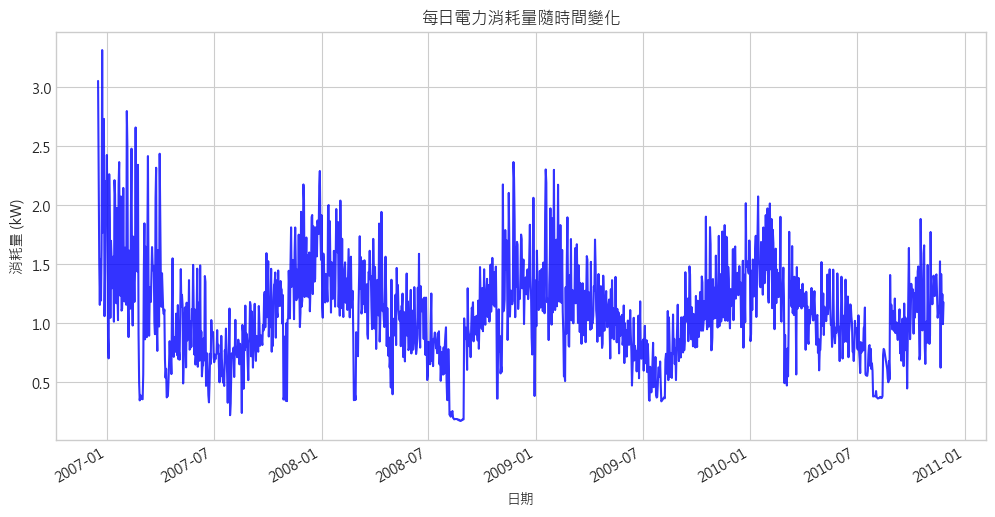

In [3]:
if not df_daily.empty:
    df_daily['Consumption_kW'].plot(title='每日電力消耗量隨時間變化', figsize=(12, 6), color='blue', alpha=0.8)
    plt.ylabel('消耗量 (kW)')
    plt.xlabel('日期')
    plt.grid(True)
    plt.show()



**討論**：

從圖中可以初步觀察到，電力消耗數據存在明顯的年度週期性（每年夏季和冬季的高峰），同時也可能存在一個緩慢的上升趨勢。對於季節性波動的幅度，它似乎隨著趨勢的上升而略有增大，這可能暗示乘法模型會是更合適的選擇，但我們將在接下來的步驟中比較兩種模型。

## 3. 使用 `seasonal_decompose` 進行時間序列分解

`statsmodels` 庫中的 `seasonal_decompose` 函數提供了方便的工具來執行時間序列的經典分解。它使用移動平均法來估計趨勢和季節性。

### `seasonal_decompose` 關鍵參數：
-   `x`: 要分解的時間序列，必須是 Pandas Series，且索引必須是 `DatetimeIndex`。
-   `model`: 指定分解模型，可以是 `'additive'` (加法) 或 `'multiplicative'` (乘法)。
-   `period`: 季節性週期的長度。這是最關鍵的參數。對於每日資料，年度季節性的週期是 365 天 (或 365.25 天以考慮閏年)；對於每小時資料，日週期是 24 小時，週週期是 `24*7=168` 小時。

**注意**：`seasonal_decompose` 在序列的開始和結束處會因無法完全計算移動平均而產生缺失值 (NaN)。為了獲得清晰的分解結果，通常建議對數據的中間部分進行分解，或者確保數據足夠長以覆蓋多個週期。

正在執行時間序列分解 (加法模型與乘法模型)...
使用 period=365 進行分解，資料筆數=1433
時間序列分解完成！


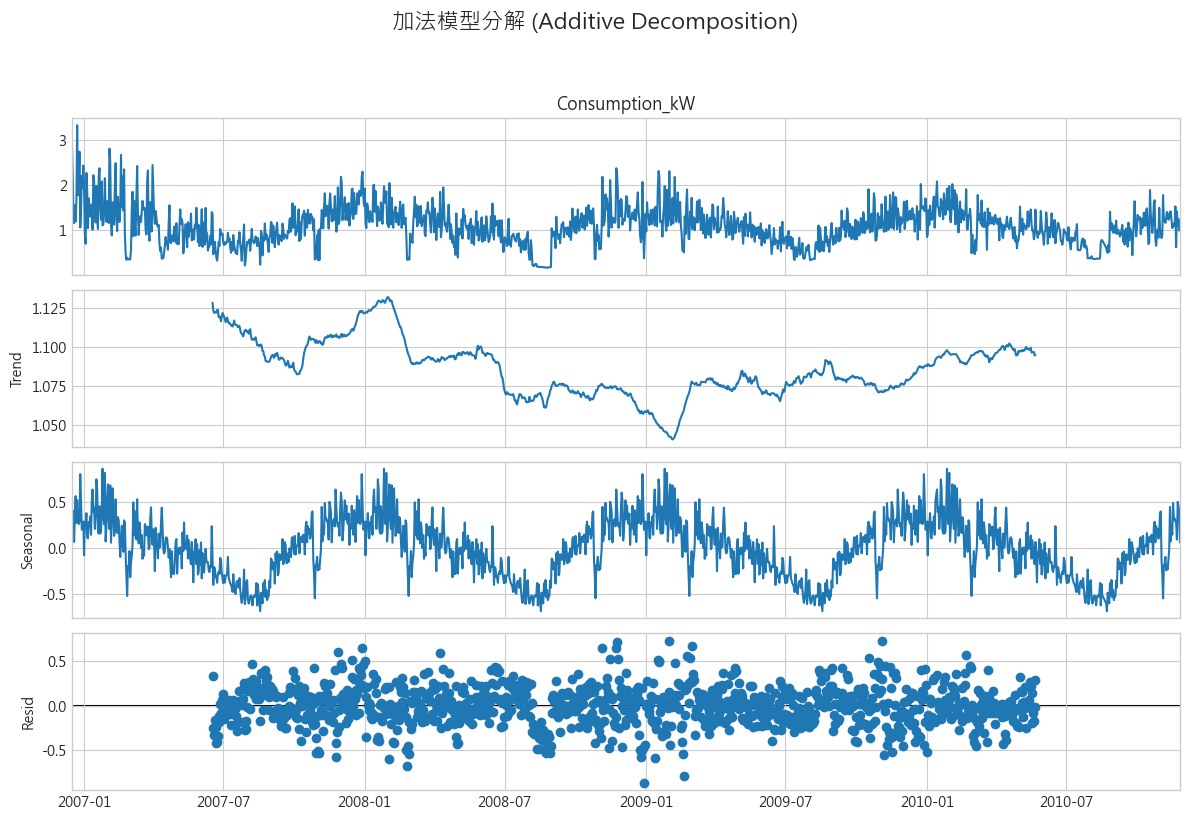

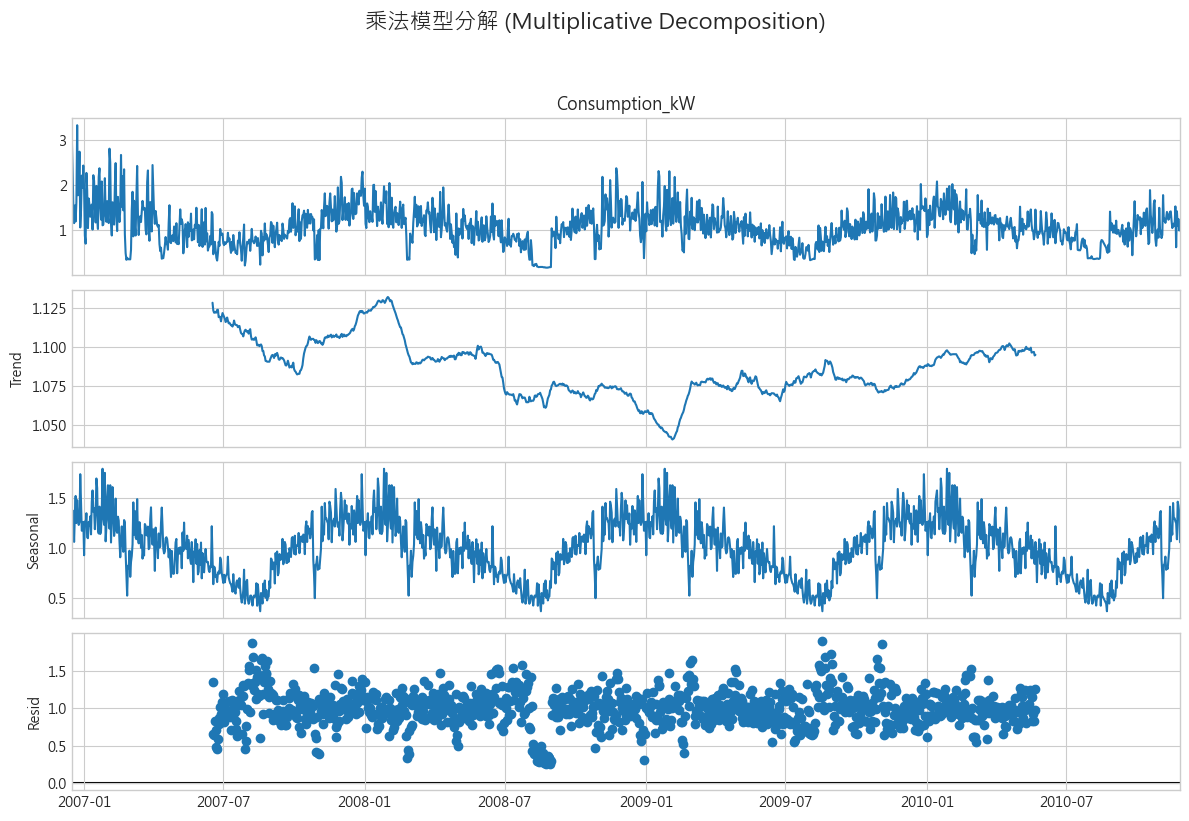

In [22]:
print("正在執行時間序列分解 (加法模型與乘法模型)...")

# 我們只取其中幾年的資料來分解，避免邊界效應影響太大，以獲得更穩定的結果
# 選擇 2015 到 2017 年的數據進行分解
if not df_daily.empty:
    # 取得完整資料範圍，確保有足夠長度進行分解
    # seasonal_decompose 需要至少 2 個週期的資料（此處 period=365，需至少 730 筆）
    # 若資料長度不足，則自動調整 period
    series = df_daily['Consumption_kW']
    n_obs = len(series)
    min_period = 2  # 至少兩個觀測值才能分解
    # 預設 period=365，若資料不足則自動縮小 period
    period = 365 if n_obs >= 730 else max(min_period, n_obs // 2)

    if n_obs < 4:
        print(f"資料筆數過少（{n_obs}），無法進行分解。")
    else:
        print(f"使用 period={period} 進行分解，資料筆數={n_obs}")

        decomposition_additive = seasonal_decompose(
            series,
            model='additive',
            period=period
        )
        decomposition_multiplicative = seasonal_decompose(
            series,
            model='multiplicative',
            period=period
        )

        print("時間序列分解完成！")

        fig_add = decomposition_additive.plot()
        fig_add.set_size_inches(12, 8)
        fig_add.suptitle('加法模型分解 (Additive Decomposition)', y=1.02, fontsize=16)

        fig_mul = decomposition_multiplicative.plot()
        fig_mul.set_size_inches(12, 8)
        fig_mul.suptitle('乘法模型分解 (Multiplicative Decomposition)', y=1.02, fontsize=16)

        fig_add.tight_layout(rect=[0, 0, 1, 0.98])
        fig_mul.tight_layout(rect=[0, 0, 1, 0.98])
        plt.show()
else:
    print("資料集為空，無法執行時間序列分解。")



In [26]:
decomposition_multiplicative

In [27]:
decomposition_multiplicative.__dict__["_seasonal"]

# decomposition_multiplicative._trend

Datetime
2006-12-16    1.133830
2006-12-17    1.376894
2006-12-18    1.306636
2006-12-19    1.060240
2006-12-20    1.335776
                ...   
2010-11-22    1.086470
2010-11-23    1.463928
2010-11-24    1.425111
2010-11-25    1.355360
2010-11-26    1.056837
Name: seasonal, Length: 1433, dtype: float64

### 結果分析與討論：

`seasonal_decompose` 的輸出包含了四個主要部分：

1.  **Observed (原始觀測值)**: 顯示原始時間序列的數據。
2.  **Trend (趨勢)**: 提取出的趨勢成分。這是一條平滑的曲線，反映了資料的長期走向，例如電力消耗的整體增長趨勢。
3.  **Seasonal (季節性)**: 提取出的季節性成分。這是一個重複的模式，其週期與我們設定的 `period` (365 天) 相符。從圖中可以清楚地看到每年夏季和冬季的電力消耗高峰。
4.  **Resid (殘差 / Noise)**: 移除趨勢和季節性成分後，時間序列中剩餘的隨機、不規則的波動。理想情況下，殘差應該是沒有明顯模式的白噪音，這表示趨勢和季節性已被成功捕捉。

**加法模型 vs. 乘法模型**：
在這個電力消耗的例子中，兩種模型的分解結果非常相似。然而，如果仔細觀察，乘法模型的殘差（`Resid` 圖）在趨勢較高（即整體消耗量較高）的部分，其波動幅度可能看起來稍微更穩定一些。這可能暗示乘法模型在這種情況下（季節性波動幅度隨趨勢增長而擴大）是更合適的選擇。在實際應用中，通常會比較兩種模型的殘差分佈，選擇殘差更接近隨機噪音的模型。

## 4. 如何利用分解後的成分進行特徵工程？

時間序列分解不僅提供了對數據的深入理解，其分解出的趨勢和季節性成分本身就是極具預測能力的特徵，可以直接作為機器學習模型的輸入。此外，我們還可以利用這些成分來創建新的、轉換後的序列，例如去季節性或去趨勢的序列，這對於某些模型的訓練非常有幫助，特別是那些要求輸入數據平穩性的模型。

**常見的應用方式**：
-   直接使用 `trend` 和 `seasonal` 成分作為額外特徵。
-   創建 **去季節性 (De-seasonalized)** 序列：這移除了重複的季節性模式，只保留了趨勢和殘差。對於加法模型，`Observed - Seasonal = Trend + Residual`；對於乘法模型，`Observed / Seasonal = Trend * Residual`。這種序列有助於觀察和建模長期的非季節性變化。
-   創建 **去趨勢 (De-trended)** 序列：這移除了長期趨勢，只保留了季節性和殘差。對於加法模型，`Observed - Trend = Seasonality + Residual`；對於乘法模型，`Observed / Trend = Seasonality * Residual`。這種序列有助於分析和建模週期性模式。

In [30]:
print("正在將分解結果添加到 DataFrame 中並創建衍生特徵...")

# 檢查分解物件是否有 _trend, _seasonal, _resid 屬性且這些 Series 長度與 df_daily 相符
if (
    not df_daily.empty and
    hasattr(decomposition_multiplicative, "_trend") and
    hasattr(decomposition_multiplicative, "_seasonal") and
    hasattr(decomposition_multiplicative, "_resid") and
    len(decomposition_multiplicative._trend.dropna()) > 0 and
    len(decomposition_multiplicative._seasonal.dropna()) > 0 and
    len(decomposition_multiplicative._resid.dropna()) > 0
):
    df_decomposed = df_daily.copy()
    # 只對齊分解後的索引（通常會比原始資料短，因為頭尾有 NaN）
    df_decomposed = df_decomposed.loc[decomposition_multiplicative._trend.index]
    df_decomposed['trend'] = decomposition_multiplicative._trend
    df_decomposed['seasonal'] = decomposition_multiplicative._seasonal
    df_decomposed['residual'] = decomposition_multiplicative._resid

    # 創建一個去季節性 (de-seasonalized) 的序列
    df_decomposed['deseasonalized'] = df_decomposed['Consumption_kW'] / df_decomposed['seasonal']

    # 創建一個去趨勢 (de-trended) 的序列
    df_decomposed['detrended'] = df_decomposed['Consumption_kW'] / df_decomposed['trend']

    # 移除因分解操作產生的 NaN 值 (通常是序列的開頭和結尾)
    df_decomposed.dropna(inplace=True)

    print("分解特徵與衍生序列創建完成！")
    print("加入分解特徵後的資料 (前5筆)：")
    display(df_decomposed.head())
else:
    print("無法創建分解特徵，請確認分解物件的 _trend/_seasonal/_resid 屬性存在且不為空，或資料集是否為空。")

正在將分解結果添加到 DataFrame 中並創建衍生特徵...
分解特徵與衍生序列創建完成！
加入分解特徵後的資料 (前5筆)：


,Consumption_kW,trend,seasonal,residual,deseasonalized,detrended
Datetime,,,,,,
2007-06-17,1.352146,1.128657,0.890516,1.345302,1.518384,1.198013
2007-06-18,0.471163,1.123712,0.635656,0.659619,0.741222,0.419291
2007-06-19,0.585786,1.122253,0.812232,0.642641,0.721205,0.521973
2007-06-20,0.746032,1.122238,0.799437,0.831550,0.933197,0.664772
2007-06-21,0.560379,1.122777,0.708547,0.704401,0.790885,0.499101


**結果解讀與討論**：

現在，`df_decomposed` DataFrame 包含了原始的電力消耗數據，以及從乘法模型分解出的趨勢、季節性和殘差成分。此外，我們還創建了 `deseasonalized` (去季節性) 和 `detrended` (去趨勢) 序列。
-   `deseasonalized` 序列移除了明顯的年度週期性波動，只保留了長期趨勢和隨機噪音。這對於建立不受季節性影響的長期預測模型非常有用。
-   `detrended` 序列則移除了長期趨勢，只留下了週期性波動和隨機噪音。這對於分析純粹的季節性模式或應用要求平穩性的模型非常有用。
這些新的序列和成分可以作為強大的特徵，為機器學習模型提供更精確和有針對性的資訊，從而提升模型的預測能力。

### 4.1 視覺化去季節性和去趨勢後的序列：確認分解效果

視覺化分解後的序列是確認分解效果的關鍵步驟。通過將原始序列與去季節性或去趨勢的序列進行對比，我們可以直觀地看到這些操作如何成功地移除了特定的時間模式。

In [ ]:
if not df_decomposed.empty:
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10), sharex=True) # sharex=True 讓兩個子圖的 x 軸同步

    # 繪製原始序列與去季節化序列
    df_decomposed[['Consumption_kW', 'deseasonalized']].plot(ax=ax1, title='原始電力消耗量 vs. 去季節性消耗量', color=['blue', 'orange'], alpha=0.8)
    ax1.set_ylabel('消耗量 (kW)')
    ax1.legend(['原始消耗量', '去季節性消耗量'])
    ax1.grid(True)

    # 繪製原始序列與去趨勢序列
    df_decomposed[['Consumption_kW', 'detrended']].plot(ax=ax2, title='原始電力消耗量 vs. 去趨勢消耗量', color=['blue', 'green'], alpha=0.8)
    ax2.set_ylabel('消耗量 (kW)')
    ax2.legend(['原始消耗量', '去趨勢消耗量'])
    ax2.set_xlabel('日期')
    ax2.grid(True)

    plt.tight_layout() # 自動調整佈局
    plt.show()
else:
    print("分解後的資料為空，無法視覺化。")



**討論**：

從上圖可以看出，`deseasonalized` 序列成功移除了明顯的年度週期性波動，曲線變得更加平滑，只突顯了長期趨勢。而 `detrended` 序列則移除了長期趨勢，只留下了週期性波動。這些視覺化結果驗證了時間序列分解的有效性，並且這些處理後的序列可以直接作為更「純粹」的預測信號，用於建立模型，尤其對於需要平穩性的傳統時間序列模型。在實務中，可以將這些分解成分單獨作為特徵，或將原始數據替換為去季節性/去趨勢的數據來訓練模型。

## 5. 總結：時間序列分解的理論與實踐

時間序列分解是理解和預處理時間序列資料的基石之一。它使我們能夠將複雜的原始序列拆解為更簡單、更易於解釋的趨勢、季節性、殘差成分，從而為後續的分析、特徵工程和模型構建提供清晰的指引。本節我們學習了以下核心知識點：

| 概念/方法 | 核心作用 | 實作工具/考量點 |
|:---|:---|:---|
| **時間序列分解** | 將序列拆分為趨勢、季節性、殘差 | 深入理解資料結構 |
| **加法模型** | 季節性波動幅度穩定 | `seasonal_decompose(model='additive')` |
| **乘法模型** | 季節性波動幅度隨趨勢成比例變化 | `seasonal_decompose(model='multiplicative')` |
| **趨勢/季節性特徵** | 作為模型輸入，捕捉長期走向和重複模式 | 直接使用分解結果的 `.trend`, `.seasonal` 屬性 |
| **去季節性/去趨勢序列** | 移除特定模式，簡化數據，適用於平穩性要求模型 | 觀測值 - 季節性 / 觀測值 / 季節性 (視模型) |

在實際應用中，時間序列分解的結果可以多種方式應用於機器學習模型：直接將趨勢、季節性成分作為特徵；或者預處理原始序列，將去季節性或去趨勢的序列作為目標變數或輸入特徵。選擇哪種模型（加法或乘法）和如何利用分解成分，通常需要結合對業務問題的深入理解、資料的探索性分析，以及對模型假設的考量。這是一個迭代和實踐的過程，旨在找到最佳的預測策略.

---

### 4.2 進階討論：常見且有效的進階時間序列建模策略，稱為「分而治之」(divide-and-conquer) 或「組合建模」(ensemble/decomposition modeling)：


## 分解再構築 !!!!!!!!!!!!
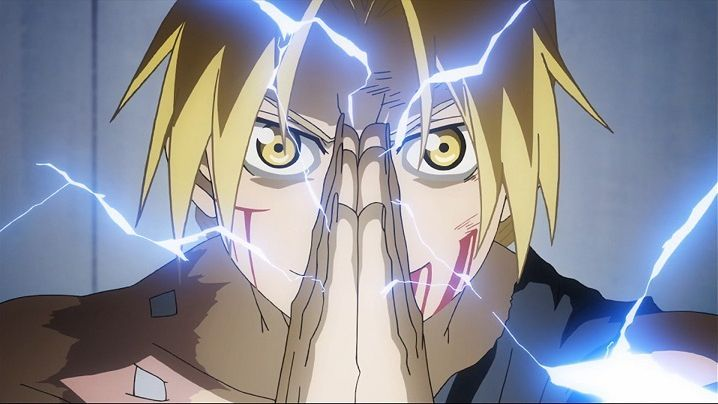


- **步驟一：分別建模**
  - 對 `deseasonalized`（去季節性）序列建立一個專注於長期趨勢與隨機波動的模型（如回歸、ARIMA、機器學習等）。
  - 對 `detrended`（去趨勢）序列建立一個專注於季節性模式的模型（如週期性回歸、Fourier、季節性ARIMA等）。

- **步驟二：分別預測**
  - 針對未來時間點，分別預測 deseasonalized 與 detrended 的值。

- **步驟三：合併預測結果**
  - 若採用乘法分解，最終預測值為：`預測值 = deseasonalized_pred * detrended_pred`
  - 若採用加法分解，則為：`預測值 = deseasonalized_pred + detrended_pred`

**優點**：
- 各子模型可針對不同訊號特性（趨勢/季節性）做最佳化，提升預測準確率。
- 可靈活選擇最適合各成分的演算法。

**注意事項**：
- 合併時需確保時間對齊。
- 若有殘差成分，亦可單獨建模或視為噪音。

**實務應用**：  
此策略常見於能源、金融、零售等領域的高階預測系統，尤其適合複雜且多重週期性資料。可參考「分解-重組」(decompose-and-recombine) 或「混合模型」(hybrid/ensemble time series model) 相關文獻與案例。